In [1]:
# Ver outros colors maps
# Verificar a escala do color map (normaliza ?)
# Olhar com cuidado ver se nao tem nenhum bug
# Tentar testar em um dataset normal pra ver se é isso mesmo

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
from my_functions import get_img_array, get_run_logdir, get_model_dir, make_gradcam_heatmap

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  786M    1 10.8M    0     0  11.1M      0  0:01:10 --:--:--  0:01:10 11.1M
  4  786M    4 34.6M    0     0  17.5M      0  0:00:44  0:00:01  0:00:43 17.5M
  7  786M    7 57.9M    0     0  19.4M      0  0:00:40  0:00:02  0:00:38 19.4M
 10  786M   10 83.2M    0     0  20.9M      0  0:00:37  0:00:03  0:00:34 20.9M
 13  786M   13  106M    0     0  21.3M      0  0:00:36  0:00:04  0:00:32 21.3M
 16  786M   16  131M    0     0  21.9M      0  0:00:35  0:00:05  0:00:30 24.0M
 19  786M   19  155M    0     0  22.2M      0  0:00:35  0:00:06  0:00:29 24.1M
 22  786M   22  179M    0     0  22.4M      0  0:00:35  0:00:07  0:00:28 24.2M
 25  786M   25  203M    0     0  22.6M      0  0:00:34  0:00:08  0:00:26 24.1M
 28  786M   28  227M    0     0  22.8M      0  0:00

In [7]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1578 images


In [10]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [16]:
data_dir = 'PetImages'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


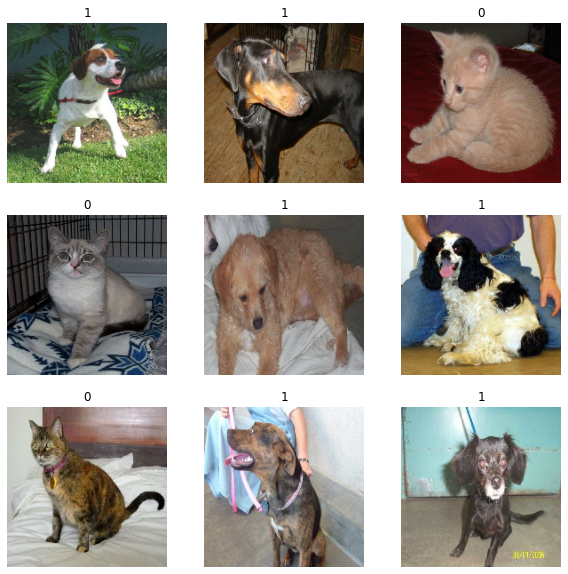

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# base_model = keras.applications.Xception(
#     weights="imagenet",  # Load weights pre-trained on ImageNet.
#     input_shape=(img_height, img_width, 3),
#     include_top=False,
# )  # Do not include the ImageNet classifier at the top.

base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
)

In [24]:
inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
   [
       layers.RandomFlip("horizontal"), 
       layers.RandomRotation(0.1)
   ]
)
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x) 
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

base_model.trainable = False # Freeze base model

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
conv2d_407 (Conv2D)          (None, 4, 4, 128)         1769600   
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0   

In [25]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

epochs = 100
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_cb, early_stopping_cb])

Epoch 1/100
586/586 [==============================] - 102s 156ms/step - loss: 0.1438 - accuracy: 0.9655 - val_loss: 0.0621 - val_accuracy: 0.9801
Epoch 2/100
586/586 [==============================] - 80s 136ms/step - loss: 0.0694 - accuracy: 0.9761 - val_loss: 0.0437 - val_accuracy: 0.9865
Epoch 3/100
586/586 [==============================] - 80s 136ms/step - loss: 0.0549 - accuracy: 0.9797 - val_loss: 0.0486 - val_accuracy: 0.9855
Epoch 4/100
586/586 [==============================] - 81s 138ms/step - loss: 0.0545 - accuracy: 0.9806 - val_loss: 0.0480 - val_accuracy: 0.9865
Epoch 5/100
586/586 [==============================] - 88s 150ms/step - loss: 0.0571 - accuracy: 0.9793 - val_loss: 0.0466 - val_accuracy: 0.9836
Epoch 6/100
586/586 [==============================] - 90s 154ms/step - loss: 0.0498 - accuracy: 0.9811 - val_loss: 0.0783 - val_accuracy: 0.9846
Epoch 7/100
586/586 [==============================] - 89s 153ms/step - loss: 0.0573 - accuracy: 0.9814 - val_loss: 0.0440 

In [26]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

epochs = 100

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_cb, early_stopping_cb])

run_modeldir = get_model_dir()
model.save(run_modeldir)

Epoch 1/100
586/586 [==============================] - 286s 457ms/step - loss: 0.0442 - accuracy: 0.9852 - val_loss: 0.0260 - val_accuracy: 0.9898
Epoch 2/100
586/586 [==============================] - 263s 449ms/step - loss: 0.0281 - accuracy: 0.9900 - val_loss: 0.0264 - val_accuracy: 0.9893
Epoch 3/100
586/586 [==============================] - 261s 446ms/step - loss: 0.0184 - accuracy: 0.9930 - val_loss: 0.0274 - val_accuracy: 0.9919
Epoch 4/100
586/586 [==============================] - 260s 443ms/step - loss: 0.0158 - accuracy: 0.9941 - val_loss: 0.0396 - val_accuracy: 0.9906
Epoch 5/100
586/586 [==============================] - 260s 444ms/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.0409 - val_accuracy: 0.9878
Epoch 6/100
586/586 [==============================] - 250s 426ms/step - loss: 0.0135 - accuracy: 0.9953 - val_loss: 0.0305 - val_accuracy: 0.9898
Epoch 7/100
586/586 [==============================] - 259s 442ms/step - loss: 0.0131 - accuracy: 0.9964 - val_loss: 0

In [27]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent cat and 0.00 percent dog.


In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
conv2d_407 (Conv2D)          (None, 4, 4, 128)         1769600   
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0   

In [52]:
model = keras.models.load_model("my_models\\run_2021_10_30-17_55_21")

In [5]:
img_path = "PetImages/Dog/500.jpg"

In [6]:
from IPython.display import Image, display

In [7]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

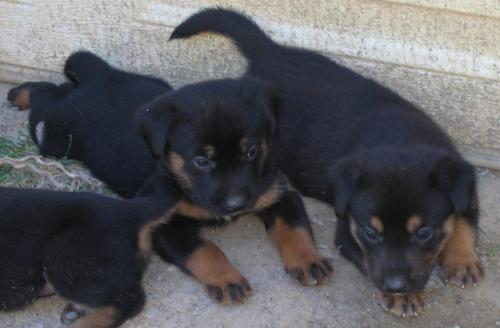

In [8]:
display(Image(img_path))

In [11]:
img_array = preprocess_input(get_img_array(img_path, size=image_size))

In [12]:
model.layers[-1].activation = None

In [13]:
preds = model.predict(img_array)
preds

array([[-0.5878903]], dtype=float32)

In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
conv2d_407 (Conv2D)          (None, 4, 4, 128)         1769600   
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0   

In [15]:
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_407')

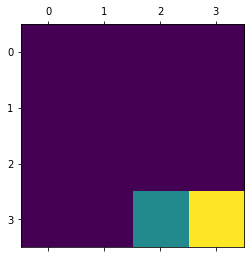

In [16]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [17]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

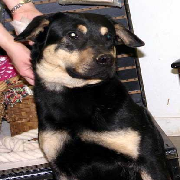

In [50]:
img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
img

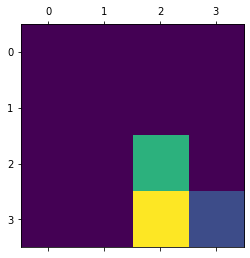

In [56]:
img_array = preprocess_input(get_img_array(img_path, size=image_size))
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_407')
plt.matshow(heatmap)
plt.show()

In [54]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
conv2d_407 (Conv2D)          (None, 4, 4, 128)         1769600   
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0   

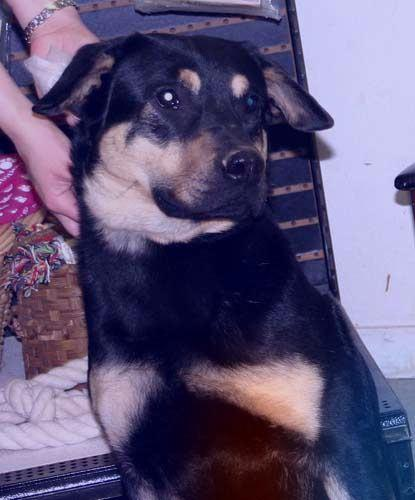

In [36]:
img_path = "PetImages/Dog/21.jpg"
img_array = preprocess_input(get_img_array(img_path, size=image_size))
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_407')
save_and_display_gradcam(img_path, heatmap)

In [38]:
make_gradcam_heatmap(img_array, model, 'conv2d_407')


array([[-0., -0., -0., -0.],
       [-0., -0., -0., -0.],
       [-0., -0., -0., -0.],
       [-0., -0., -0., -0.]], dtype=float32)

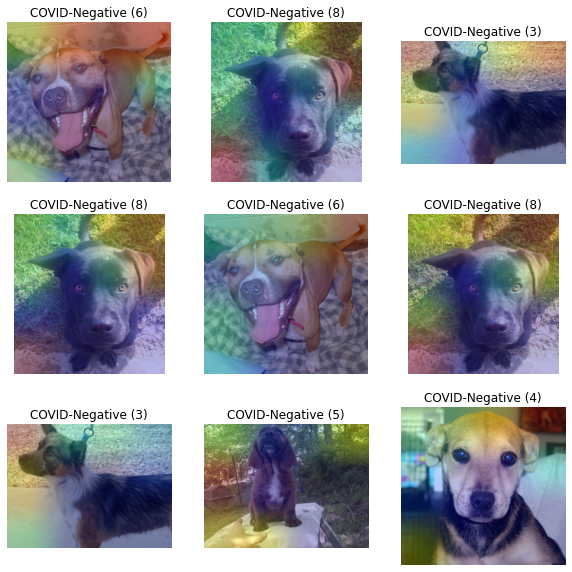

In [13]:
plt.figure(figsize=(10, 10))
end = False
for i in range(9):
  rand = random.randint(3, 9)
  ax = plt.subplot(3, 3, i + 1)
  img_path = "PetImages/Dog/{}.jpg".format(rand)
  img_array = get_img_array(img_path, size=image_size)
  superimposed_img = superimpose_gradcam(img_array, 
                    current_model=model, 
                    last_conv_layer_name='conv2d_407', 
                    img_path=img_path,
                    alpha=0.4)
  plt.imshow(superimposed_img)
  plt.title('COVID-Negative ({})'.format(rand))
  plt.axis("off")

In [57]:
model_builder = keras.applications.xception.Xception

In [58]:
model = model_builder(weights="imagenet")

In [59]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [47]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 149, 149, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_4[0][0]      
________________________________________________________________________________